# 2. Exploratory Data Analysis (EDA)

In [20]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve

from utils import *
import warnings

# Setting other parameters 
pd.set_option('display.max_columns', 200)
warnings.filterwarnings('ignore')

In [2]:
# Load the data into the dataframe "data"
features = pd.read_csv('transactions_obf.csv', parse_dates=['transactionTime'])
labels = pd.read_csv('labels_obf.csv', parse_dates=['reportedTime'])

#print (f'features \n \n shape: \n {features.shape}\n \n {features.head()}') # uncommnet this line to see a preview of features data
#print (f'\n labels \n \n shape: \n {labels.shape}\n \n {labels.head()}') # # uncommnet this line to see a preview of labels data

First of all, we need to do some data manipulation.
Because labels and features are separated files we need to merge both datasets

In [3]:
# append flags to transaction data frame
data=features.merge(labels, on = 'eventId', how='outer')

Labels data has only 875 entries which corresponds to the fraudulent transactions. We therefore will assume that the rest are safe transactions.

In [4]:
# create a label column where 0 represents secure transaction while 1 represents a fraudulent transaction
data['label'] = [0 if pd.isnull(val) else 1 for val in data['reportedTime']]
data = data.drop('reportedTime', axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118621 entries, 0 to 118620
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   transactionTime    118621 non-null  datetime64[ns, UTC]
 1   eventId            118621 non-null  object             
 2   accountNumber      118621 non-null  object             
 3   merchantId         118621 non-null  object             
 4   mcc                118621 non-null  int64              
 5   merchantCountry    118621 non-null  int64              
 6   merchantZip        95616 non-null   object             
 7   posEntryMode       118621 non-null  int64              
 8   transactionAmount  118621 non-null  float64            
 9   availableCash      118621 non-null  int64              
 10  label              118621 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(1), int64(5), object(4)
memory usage: 10.9+ MB


## 2.1. Is there a preferential day for for hackers to operate?

Let's now extract the information from the trasaction date. We will consder only the day where transaction was performed.

In [5]:
# create a copy of the original dataset
dataset= data.copy()

# create an additional column 'week_day'
dataset['week_day'] = dataset['transactionTime'].dt.day_name()

# drop 'transactionTime' columns
dataset=dataset.drop('transactionTime', axis=1)

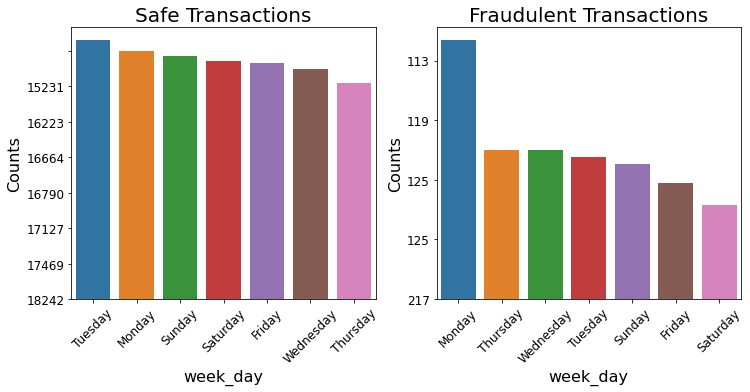

In [6]:
is_fraud = dataset[dataset['label']==1]# data for fraudulent transactions
is_safe =  dataset[dataset['label']==0]# data for safe transactions

fraud_op_wday = is_fraud.groupby('week_day')['label'].agg('count').reset_index()
fraud_op_wday = fraud_op_wday.rename(columns={'label':'Counts'}).sort_values(by='Counts', ascending=False)

safe_op_wday = is_safe.groupby('week_day')['label'].agg('count').reset_index()
safe_op_wday = safe_op_wday.rename(columns={'label':'Counts'}).sort_values(by='Counts', ascending=False)

# Plot
fig, axs = plt.subplots(1,2, figsize=(12,5))
sns.barplot(ax=axs[0], data=safe_op_wday, x= 'week_day', y='Counts')
axs[0].set_title('Safe Transactions', size=20)
axs[0].set_xlabel('week_day', size=16)
axs[0].set_ylabel('Counts', size=16)
axs[0].set_xticklabels(safe_op_wday.week_day, size=12, rotation=45)
axs[0].set_yticklabels(safe_op_wday['Counts'], size=12)

sns.barplot(ax=axs[1], data=fraud_op_wday, x= 'week_day', y='Counts')
axs[1].set_title('Fraudulent Transactions', size=20)
axs[1].set_xlabel('week_day', size=16)
axs[1].set_ylabel('Counts', size=16)
axs[1].set_xticklabels(fraud_op_wday.week_day, size=12, rotation=45)
axs[1].set_yticklabels(fraud_op_wday['Counts'], size=12)

plt.show()

## * Observation

* The plots suggest that most of the fraudulent transactions are preformed on Monday. However, it could make more sense to think that transaction is performed on weekend but the banck only register it on the first working day.
* Safe transactions however, are performed any day of the week

## 2.2. Are fraudulent operations correlated with any of the category from PosEntryMode?

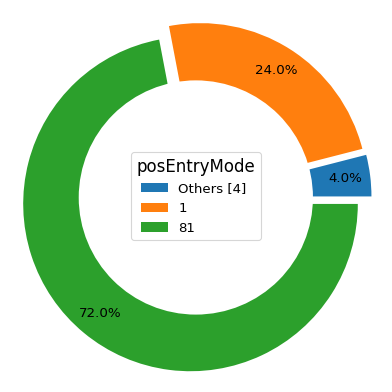

In [7]:
# plot 'posEntryMode' column 
pie_plot(dataset, 'posEntryMode')

## * Observation

* 72% of the fraudulent transactions are performed by E-Commerce, while 24% are performed by manual mode (see dictionary). The rest are less frequent (4% all together)

## 2.3. How is are countries involved in fraudulent opperations?

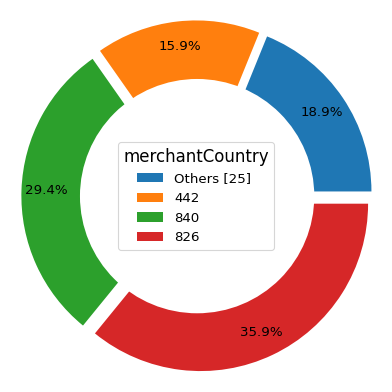

In [8]:
# plot 'posEntryMode' column 
pie_plot(dataset, 'merchantCountry', cutoff=30)

## * Observation

* It can be noticed that 81% of fraudulent transactions are performed on three different countries. ~36% of the fraudulent transactions are performed the country whose code is 826 (Not clear on dictionary). 29% for country with code 840, while ~16% for the one with 442 country code. Other countries have less than 1% of incidence on average 

# 3. Prepare data for fitting

In this section we will prepare data for fitting. Columns which are considered as useless well be dropped out from datset. For instance, both `merchantId` and `merchantZip` are not too informative if we consider the variable `merchantCountry` on the analysis.  

In [9]:
# Drop useless columns
cols = ['eventId', 'accountNumber', 'merchantId', 'merchantZip']
dataset = dataset.drop(cols, axis=1)
print (dataset.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118621 entries, 0 to 118620
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   mcc                118621 non-null  int64  
 1   merchantCountry    118621 non-null  int64  
 2   posEntryMode       118621 non-null  int64  
 3   transactionAmount  118621 non-null  float64
 4   availableCash      118621 non-null  int64  
 5   label              118621 non-null  int64  
 6   week_day           118621 non-null  object 
dtypes: float64(1), int64(5), object(1)
memory usage: 7.2+ MB
None


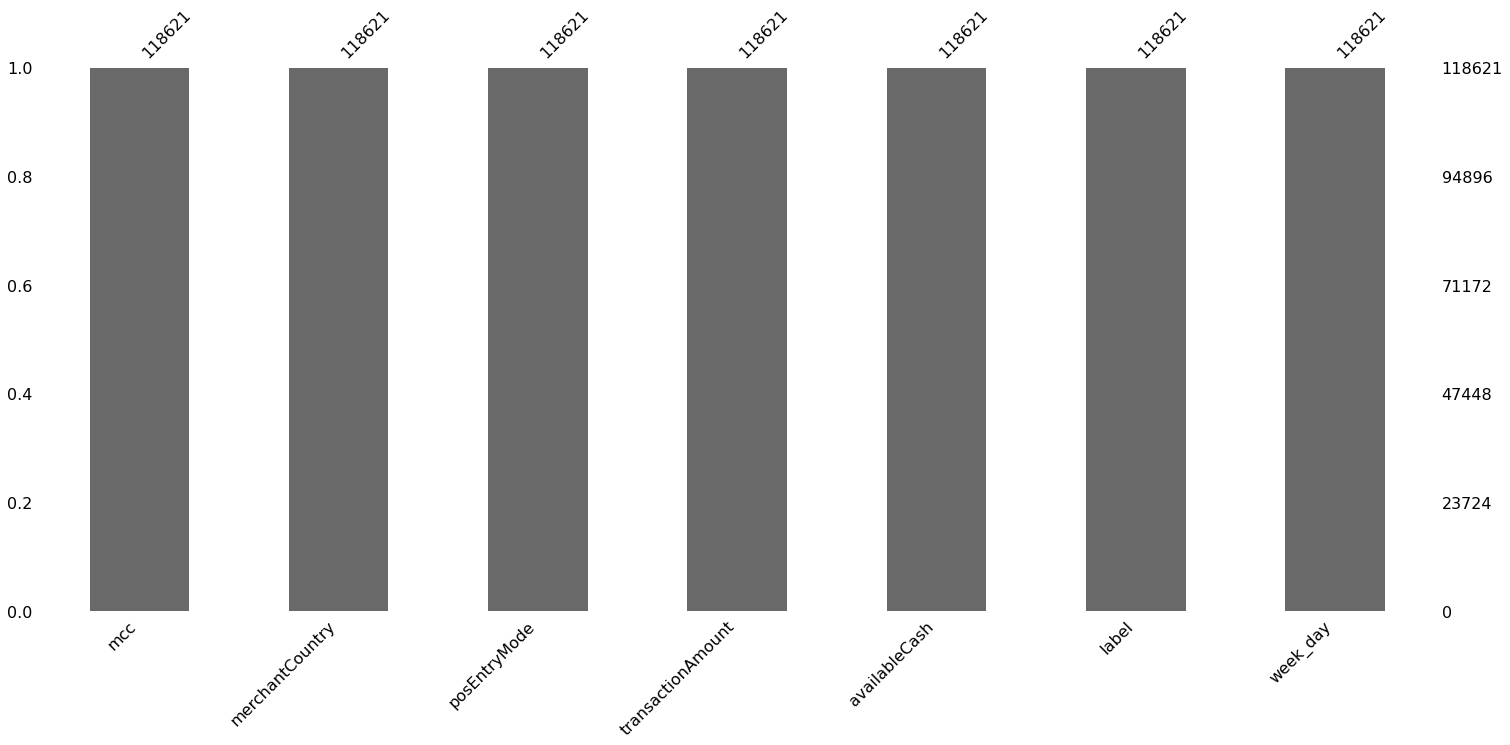

In [10]:
# check for missing values
msno.bar(dataset)
plt.show()

## Data seems to be pretty clean now. However, how are label classes distributed on the entire dataset? 

In [11]:
# Now we are going to check for data quality (label)
lebel_count = dataset.label.value_counts()
print ('Original data')
print('safe transactions:', lebel_count[0])
print('fraudulent transactions:', lebel_count[1])
print('Proportion:', round(lebel_count[0] / lebel_count[1], 2), '/ 1.0')

Original data
safe transactions: 117746
fraudulent transactions: 875
Proportion: 134.57 / 1.0


## * Observation
For each fraudulent transaction there are 134 safe transactions. So, data is heavily imbalanced and we should try to overcome this issue if we pretend to have good model performance and generalization.

There are different ways to overcome data unbalance. The simplest method is to drop observations from the majority class. Although this method works when we have a lot of observations, this is not a very elegant solution. Other way is to split the majority class in smaller data subsets where each subset should be balanced with the minority class. Then a model is trained in a separated subsets and the best model is selected. Luckily for us we have `imblearn` library with very good functions to handle imbalanced datasets. We here will use the oversample approach by using the SMOTE algorithm for data imbalance correction        

# 4. Fittig data

## Let's compare the model performance on both the original imbalanced dataset and the balanced one

roc_auc_score [LogisticRegression()]: 0.7370579314528358
acc_score [LogisticRegression()]: 0.9926238145416227
[[23550     0]
 [  175     0]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     23550
           1       0.00      0.00      0.00       175

    accuracy                           0.99     23725
   macro avg       0.50      0.50      0.50     23725
weighted avg       0.99      0.99      0.99     23725



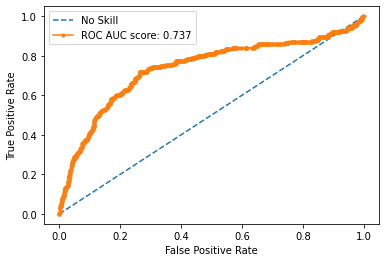

0.9926238145416227

In [12]:
# fit a logistic model on the imbalanced dataset
model = LogisticRegression()

X_train, X_test, y_train, y_test = parse_data(dataset, oversample=False)

model_fit(model, X_train, X_test, y_train, y_test)

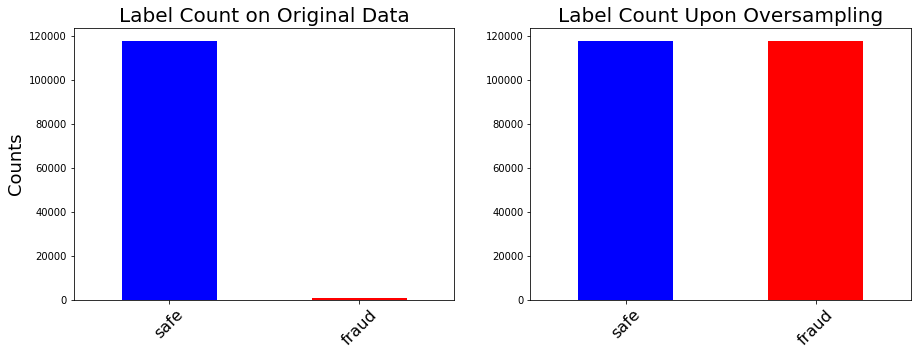

roc_auc_score [LogisticRegression()]: 0.9530953741023407
acc_score [LogisticRegression()]: 0.8818791756312988
[[33130  2194]
 [ 6151 29173]]
              precision    recall  f1-score   support

           0       0.84      0.94      0.89     35324
           1       0.93      0.83      0.87     35324

    accuracy                           0.88     70648
   macro avg       0.89      0.88      0.88     70648
weighted avg       0.89      0.88      0.88     70648



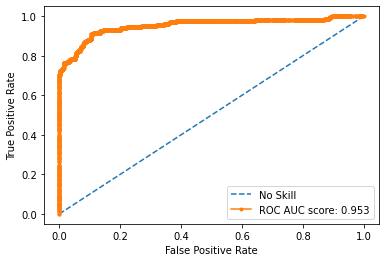

0.8818791756312988

In [13]:
# fit the same model but now on the balanced dataset
X_train, X_test, y_train, y_test = parse_data(dataset, oversample=True, checkplot=True)
model_fit(model, X_train, X_test, y_train, y_test)

## * Observation
It is clear that the model has a better performance once the data is imbalance corrected. Note how the acuracy score is overestimated in the first case and the roc-score, whish is the most suitable for accuracy test on imbalanced data, is very low.  

## 4.1. Try different models
We are interested now in finding a model with the best berformance and good prediction accuracy. To do That we wil test six different sklearn-models. In addition we will test a simple keras-based model at the end.

In [16]:
models = [
    ('logreg', LogisticRegression()),
    ('KNClassif', KNeighborsClassifier()),
    ('DTClassif', DecisionTreeClassifier()),
    ('RFClassif', RandomForestClassifier()),
    ('ABClassif', AdaBoostClassifier()),
    ('GBClassif', GradientBoostingClassifier())
]

In [17]:
X_train, X_test, y_train, y_test = parse_data(dataset, oversample=True)
scores={}
for name, model in models:
    print (f'\n Model: [{name}] \n')
    acs = model_fit(model, X_train, X_test, y_train, y_test, plot_ROC=False)
    scores[name]=acs


 Model: [logreg] 

roc_auc_score [LogisticRegression()]: 0.9504593870827307
acc_score [LogisticRegression()]: 0.8729475710565054
[[33201  2123]
 [ 6853 28471]]
              precision    recall  f1-score   support

           0       0.83      0.94      0.88     35324
           1       0.93      0.81      0.86     35324

    accuracy                           0.87     70648
   macro avg       0.88      0.87      0.87     70648
weighted avg       0.88      0.87      0.87     70648


 Model: [KNClassif] 

roc_auc_score [KNeighborsClassifier()]: 0.997812422771149
acc_score [KNeighborsClassifier()]: 0.9954138829124675
[[35195   129]
 [  195 35129]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     35324
           1       1.00      0.99      1.00     35324

    accuracy                           1.00     70648
   macro avg       1.00      1.00      1.00     70648
weighted avg       1.00      1.00      1.00     70648


 Model: [DTClassi

### 4.1.1. Voting classifier

As usual, let's now implement a voting classifier to decide wich is the bes model so far

In [18]:
vc = VotingClassifier(estimators=models, voting='soft')
vc.fit(X_train, y_train)

label_pred_vc = vc.predict(X_test)

acc_score_vc = accuracy_score(y_test, label_pred_vc)
scores['VClassif']=acc_score_vc

print(f'Accuracy Score : {acc_score_vc}')
print(f'Confusion Matrix : \n{confusion_matrix(y_test, label_pred_vc)}')
print(f'Classification Report : \n{classification_report(y_test, label_pred_vc)}')

Accuracy Score : 0.9965887215490884
Confusion Matrix : 
[[35263    61]
 [  180 35144]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     35324
           1       1.00      0.99      1.00     35324

    accuracy                           1.00     70648
   macro avg       1.00      1.00      1.00     70648
weighted avg       1.00      1.00      1.00     70648



### 4.1.2. KNN

Epoch 1/200
5152/5152 [==============================] - 23s 4ms/step - loss: 0.2421 - accuracy: 0.8858 - val_loss: 0.1801 - val_accuracy: 0.9256
Epoch 2/200
5152/5152 [==============================] - 23s 4ms/step - loss: 0.1832 - accuracy: 0.9152 - val_loss: 0.1702 - val_accuracy: 0.9257
Epoch 3/200
5152/5152 [==============================] - 23s 4ms/step - loss: 0.1616 - accuracy: 0.9278 - val_loss: 0.1457 - val_accuracy: 0.9395
Epoch 4/200
5152/5152 [==============================] - 22s 4ms/step - loss: 0.1436 - accuracy: 0.9382 - val_loss: 0.1551 - val_accuracy: 0.9316
Epoch 5/200
5152/5152 [==============================] - 22s 4ms/step - loss: 0.1345 - accuracy: 0.9430 - val_loss: 0.1302 - val_accuracy: 0.9471
Epoch 6/200
5152/5152 [==============================] - 22s 4ms/step - loss: 0.1269 - accuracy: 0.9467 - val_loss: 0.1211 - val_accuracy: 0.9546
Epoch 7/200
5152/5152 [==============================] - 22s 4ms/step - loss: 0.1207 - accuracy: 0.9497 - val_loss: 0.1102 -

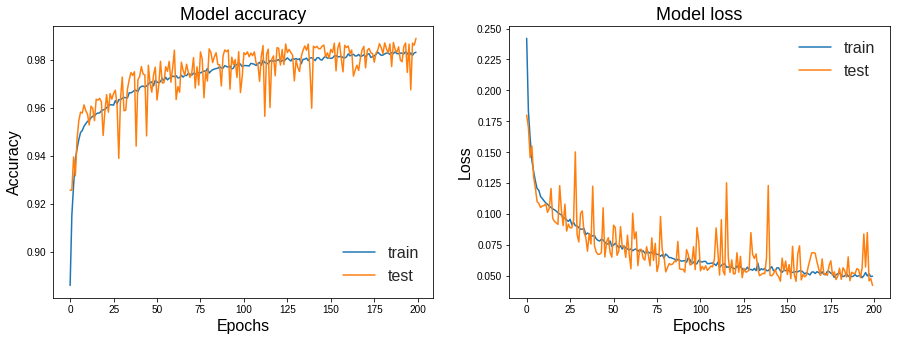

In [21]:
shape=X_train.shape[1]

ANN_model = ANN(shape) 

history = model_fit(ANN_model, X_train, X_test, y_train, y_test, ANN=True)

scores['ANN']=np.max(history.history['val_accuracy'])

print(history.history.keys())

# Plotting history
fig, axs = plt.subplots(1,2, figsize=(15, 5))
plt.style.use('seaborn-whitegrid')

# accuracy
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model accuracy', size=18)
axs[0].set_ylabel('Accuracy', size=16)
axs[0].set_xlabel('Epochs', size=16)
axs[0].legend(['train', 'test'], loc='lower right', fontsize=16)

# loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model loss', size=18)
axs[1].set_ylabel('Loss', size=16)
axs[1].set_xlabel('Epochs', size=16)
axs[1].legend(['train', 'test'], loc='upper right', fontsize=16)
plt.show()


## 4.2. Model Comparison
Now let's compare all the trained models according to their accuracy scores.

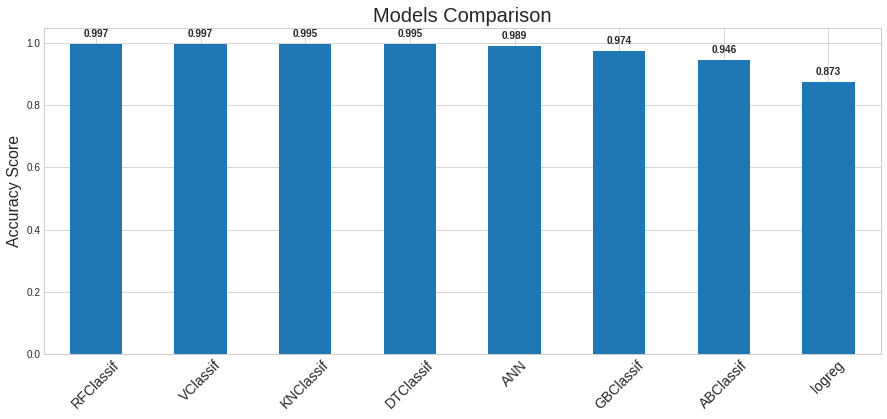

In [22]:
sc = pd.Series(scores).sort_values(ascending=False)

plt.figure(figsize=(15,6))
ax=sc.plot(kind='bar')

for rect in ax.patches:
    # Get X and Y placement of label from rect.
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    # Use Y value as label and format number with three decimal places
    label = "{:.3f}".format(y_value)

    # Create annotation
    ax.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, 5),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        weight='bold',              # Highlight labels
        ha='center',                # Horizontally center label
        va='bottom')                      # Vertically align label differently for
                                        # positive and negative values.
ax.set_xticklabels(sc.index, fontsize=14, rotation=45)
ax.set_ylabel('Accuracy Score', size=16)
ax.set_title('Models Comparison', size=20)
plt.show()